## SageMaker Model Monitor (data quality) for SageMaker Batch Transform Jobs - Model Training & Baselining Pipeline

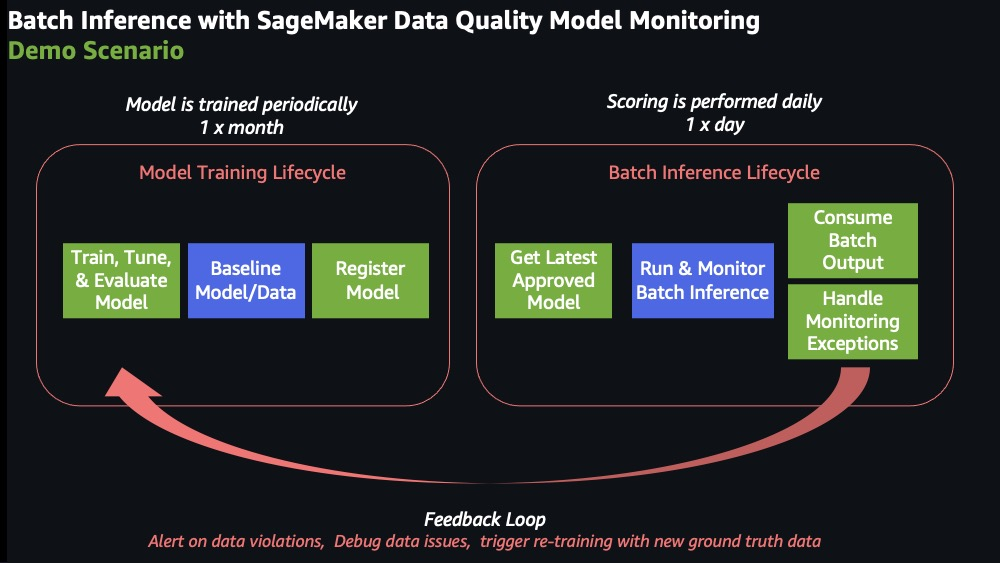

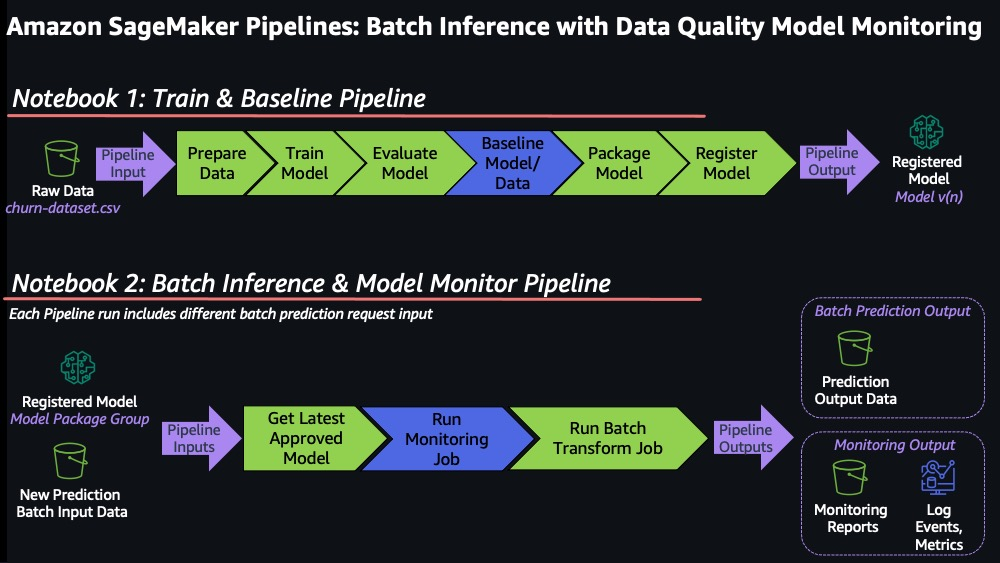

In [5]:
# Uncomment if not using latest version of SageMaker SDK
#import sys

#! pip install --upgrade pip
#!{sys.executable} -m pip install sagemaker==2.114.0
#!{sys.executable} -m pip install -U boto3

In [6]:
# If you run this notebook in SageMaker Studio, you need to make sure latest python SDK is installed and restart the kernel, 
# so please uncomment the code below, and run it.
#import IPython
#IPython.Application.instance().kernel.do_shutdown(True)  # has to restart kernel so changes are used

# Setup

In this section, we'll import libraries and setup variables needed to configure pipeline steps and construct the model build pipeline. We'll also upload the scripts that will be used for the data preprocessing and model evaluation steps to S3.  

In [7]:
import os
import time
from time import gmtime, strftime
import sagemaker
import json
import boto3
import pandas as pd

# SageMaker Job Imports (ex. Processing, Training) 
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput, ScriptProcessor

from sagemaker.model import Model
from sagemaker.inputs import TrainingInput

from sagemaker.model_monitor import DatasetFormat, model_monitoring
from sagemaker.clarify import (
    BiasConfig,
    DataConfig,
    ModelConfig
)

from sagemaker.model_metrics import ModelMetrics, MetricsSource
from sagemaker.drift_check_baselines import DriftCheckBaselines


# SageMaker Pipeline Imports 
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import ProcessingStep, TrainingStep, CreateModelStep, TransformStep
from sagemaker.workflow.model_step import ModelStep

from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)

from sagemaker.workflow.functions import Join
from sagemaker.workflow.execution_variables import ExecutionVariables

from sagemaker.workflow.pipeline_context import PipelineSession

from sagemaker.workflow.check_job_config import CheckJobConfig
from sagemaker.workflow.clarify_check_step import (
    DataBiasCheckConfig,
    ClarifyCheckStep,
)
from sagemaker.workflow.quality_check_step import (
    DataQualityCheckConfig,
    QualityCheckStep,
)

from sagemaker.workflow.parameters import (
    ParameterBoolean,
    ParameterInteger,
    ParameterString,
)

from sagemaker.workflow.steps import CacheConfig

In [8]:
# SageMaker variables
session = PipelineSession()
bucket = session.default_bucket()
role_arn= sagemaker.get_execution_role()
region = session.boto_region_name
sagemaker_client = boto3.client('sagemaker')
aws_account_id = boto3.client('sts').get_caller_identity().get('Account')

print("RoleArn: {}".format(role))

RoleArn: arn:aws:iam::171503325295:role/adminec2


In [ ]:
# Setup S3 paths for pipeline inputs, outputs, & artifacts
print("Demo Bucket: {}".format(bucket))
bucket_prefix = f"aim321-demo-model-monitor-batch-transform/{int(time.time())}"
model_artifacts = "s3://{}/{}/model-artifacts".format(bucket,bucket_prefix)
transformed_data_path = "s3://{}/{}/transformed-data".format(bucket, bucket_prefix)
raw_input_data = "s3://{}/aim321-demo-model-monitor-batch-transform/raw-customer-data/20221122/churn-dataset.csv".format(bucket) 

print("Raw Data Path: {}".format(raw_input_data))
print("Transformed Data Path: {}".format(transformed_data_path))
print("Model Artifact Path: {}".format(model_artifacts))

Demo Bucket: sagemaker-us-east-1-171503325295
Raw Data Path: s3://sagemaker-us-east-1-171503325295/aim321-demo-model-monitor-batch-transform/raw-customer-data/20221122/churn-dataset.csv
Transformed Data Path: s3://sagemaker-us-east-1-171503325295/aim321-demo-model-monitor-batch-transform/1674858568/transformed-data
Model Artifact Path: s3://sagemaker-us-east-1-171503325295/aim321-demo-model-monitor-batch-transform/1674858568/model-artifacts


### SageMaker Model Registry

Specify the model package group for registering high performing model versions. 

In [ ]:
model_package_group_name="aim321-customer-churn"

print("SageMaker Model Registry - Model Package Group:", model_package_group_name)

SageMaker Model Registry - Model Package Group: aim321-customer-churn


### Setup Step Caching Configuration

This configuration can be enabled on pipeline steps to allow SageMaker Pipelines to automatically check if a previous (successful) run of a pipeline step with the same values for specific parameters is found. If it is found, Pipelines propogates the results of that step to the next step without re-running the step saving both time and compute costs. 

In [9]:
cache_config = CacheConfig(enable_caching=True, expire_after="PT12H")

### Setup Runtime Parameters

Configurable parameters that can be passed in at runtime without changing pipeline code. 

            pipeline.start(parameters=dict(...))


In [10]:
# Setup Runtime Parameters 

# Data Preparation Step - S3 URI to input data
input_data = ParameterString(
    name="InputData", 
    default_value=raw_input_data
)

Train and baseline pipeline is part 1 of the batch inference with data quality model monitoring using SageMaker Pipelines. The necessary steps and code are within 1.SageMakerPipeline-BaselineData-Train.ipynb. Train and baseline pipeline takes the raw customer churn data as input, and generates baseline and the trained model which will be registered with the model registry for subsequent use with Batch Transform.

1-A. Configure Model Build Pipeline
1. Prepare Data Step
2. Train Model Step
3. Evaluate Model Step

1-B. Configure Steps to Baseline, Package & Register Model Version
1. Baseline Step for Data Drift Model Monitor
2. Package Model Step
3. Register Model Step

1-C. Conditional Step: Configure step to evaluate model performance

--- 
### 1-A Configure Model Build & Baseline Pipeline Steps

Model build pipeline is a three step process, 

1. Prepare Data Step
2. Train Model Step
3. Evaluate Model Step


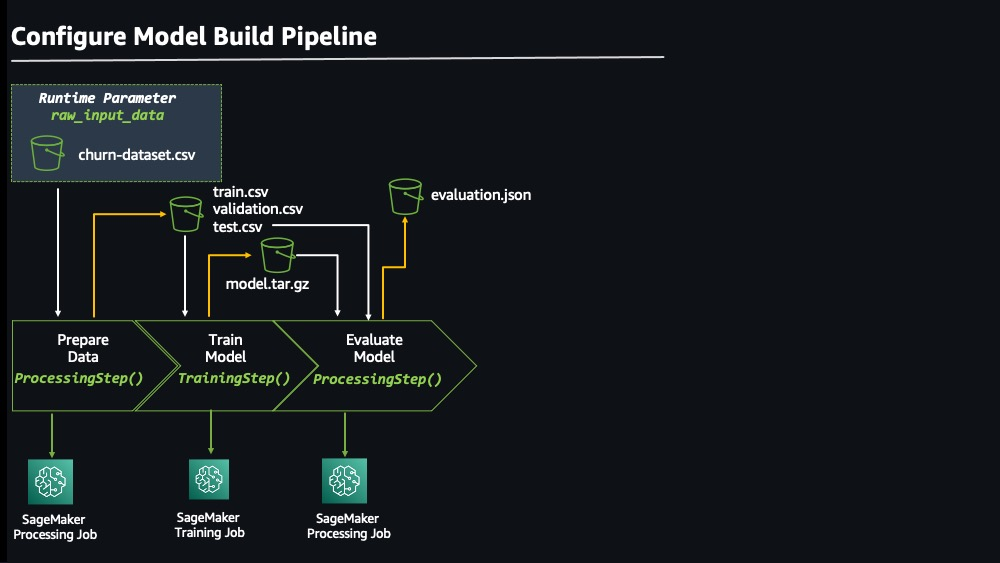

#### 1. Prepare Data Step: Configure Processing Job & Pipeline Step

Prepare data step is the first part of the three parts of model build pipeline which involves pre-processing the raw data and preparing it for training and evaluation. For processing, prepare data step uses SKLearnProcessor container. It allows to select the appropriate instance type and instance count for processing the data. Depending on the size of the data, the instance type can be changed to smaller or larger instance type. Prepare data is a [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) and utilizes *preprocessing.py* script. It reads the raw data from designated S3 bucket as input using ProcessingInput, does the necessary data processing as per the logic within *preprocessing.py*. Since *preprocessing.py* has logic for converting categorical variables from the raw data into dummy variables, this logic substantially increases number of columns as feature engineering.  It also splits the data into 3 parts for training, validation, testing. Prepare data step then writes the 3 datasets as output using ProcessingOutput to designated folders in S3. These 3 datasets are inputs for train model step and Evaluate Model Step.

In [ ]:
# Configure SageMaker Processing Job
preprocess_data_processor = SKLearnProcessor(
    framework_version='1.0-1',
    role=role_arn,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='aim321-data-preparation',
)
# Configure Pipeline Step - 'ProcessingStep'
data_preparation_step = ProcessingStep(
    name='PrepareData',
    processor=preprocess_data_processor,
    inputs=[
        ProcessingInput(
            source=input_data,
            destination='/opt/ml/processing/input'
        ),
    ],
    outputs=[
        ProcessingOutput(
            output_name='train',
            destination=f'{transformed_data_path}/train',
            source='/opt/ml/processing/train'
        ),
        ProcessingOutput(
            output_name='validation',
            destination=f'{transformed_data_path}/validation',
            source='/opt/ml/processing/validation'
        ),
        ProcessingOutput(
            output_name='test',
            destination=f'{transformed_data_path}/test',
            source='/opt/ml/processing/test'
        )
    ],
    code="s3://{}/aim321-demo-model-monitor-batch-transform/scripts/preprocessing.py".format(bucket),
    cache_config=cache_config
)

#### 2. Train Model Step: Configure Training Job & Pipeline Step

Train model step is the second part of the three parts of model build pipeline which involves training the appropriate model. Based on the target variable of the dataset, it is a binary classification problem. XGBoost model is selected for this, for which xgboost container is utilized for training. Train model step is [TrainingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.TrainingStep) within pipeline and takes train and validation data from prepare data set as part of TrainingInput. Train model step trains the xgboost model and saves the model in S3 bucket as *model.tar.gz* file. *model.tar.gz* file is an essential file which will be utilized as next steps for evaluate model step and for model registry later on.

In [ ]:
# Configure SageMaker Training Job

xgboost_container = sagemaker.image_uris.retrieve(framework="xgboost",region=region,version="1.0-1",py_version="py3",)
estimator = sagemaker.estimator.Estimator(
    image_uri=xgboost_container, 
    role=role_arn,
    output_path=f'{model_artifacts}',
    instance_count=1, 
    instance_type='ml.m5.2xlarge', 
    volume_size=5, # 5 GB 
)

# Tuned hyperparameters
estimator.set_hyperparameters(
    objective="binary:logistic",
    num_round=48,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
    silent=0,
)
# Configure Pipeline Step - 'TrainingStep'
training_step = TrainingStep(
    name='TrainModel',
    estimator=estimator,
    inputs={
        'train': TrainingInput(
            s3_data=data_preparation_step.properties.ProcessingOutputConfig.Outputs[
                'train'
            ].S3Output.S3Uri,
            content_type='text/csv'
        ),
        'validation': TrainingInput(
            s3_data=data_preparation_step.properties.ProcessingOutputConfig.Outputs[
                'validation'
            ].S3Output.S3Uri,
            content_type='text/csv'
        )
    },
    cache_config=cache_config
)


/opt/conda/lib/python3.7/site-packages/sagemaker/workflow/steps.py:444: UserWarning: Profiling is enabled on the provided estimator. The default profiler rule includes a timestamp which will change each time the pipeline is upserted, causing cache misses. If profiling is not needed, set disable_profiler to True on the estimator.
  warnings.warn(msg)


#### 3. Evaluate Model Step: Configure Processing Job & Pipeline Step

Evaluate model step is the last step of the of the three parts of model build pipeline and involves evaluating the trained model with test data. For processing, evaluate model step uses [ScriptProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.processing.ScriptProcessor) container. It allows to select the appropriate instance type and instance count for processing the data. Evaluate model step is a [ProcessingStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.steps.ProcessingStep) and utilizes *evaluate.py* script. It unpickles and reads the trained model from *model.tar.gz* from S3 bucket, which was output of train model step. It utilizes the test data from from prepare data step to evaluate the model and generates performance metrics (accuracy, area under curve) as output. As part of ProcessingStep, evaluate model step uses ProcessingInput as input and ProcessingOutput for output. The evaluation metrics are saved as .json file which is required for later steps related to configuring baseline step and configuring conditional step.

In [ ]:
# Configure SageMaker Processing Job
evaluation_processor = ScriptProcessor(
    image_uri=xgboost_container,
    command=["python3"],
    role=role_arn,
    instance_type='ml.m5.xlarge',
    instance_count=1,
    base_job_name='evaluation',
    sagemaker_session=session,
)
# Specify where we'll store the model evaluation results so
# that other steps can access those results
evaluation_report = PropertyFile(
    name='EvaluationReport',
    output_name='evaluation',
    path='evaluation.json',
)

# Configure Pipeline Step - 'ProcessingStep'
evaluation_step = ProcessingStep(
    name='EvaluateModel',
    processor=evaluation_processor,
    inputs=[
        ProcessingInput(
            source=training_step.properties.ModelArtifacts.S3ModelArtifacts,
            destination='/opt/ml/processing/model',
        ),
        ProcessingInput(
            source=data_preparation_step.properties.ProcessingOutputConfig.Outputs['test'].S3Output.S3Uri,
            destination='/opt/ml/processing/test',
        ),
    ],
    outputs=[
        ProcessingOutput(
            output_name='evaluation', 
            source='/opt/ml/processing/evaluation',
        ),
    ],
    code="s3://{}/aim321-demo-model-monitor-batch-transform/scripts/evaluation.py".format(bucket),
    property_files=[evaluation_report],
    cache_config=cache_config
)

## 1-B. Configure Baseline Step for Data Drift Model Monitor

### ----

![Step5](./images/AIM321-Baseline-Data-1.jpg)



In order to monitor the model and data, a baseline is required. Baseline step sets the required baseline for data quality using [QualityCheckStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.quality_check_step.QualityCheckStep). Data Quality Baseline Job has two key parameters - data_quality_check_config and check_job_config. check_job_config allows to select the appropriate instance type and instance count for processing data quality check using CheckJobConfig. data_quality_check_config  sets the input path for the training data from previous prepare data step as well as path for output within S3. As output, QualityCheckStep generates two .json files, statistics.json and constraints.json which are saved in S3 buckets. statistics.json contains statistics (like mean, sum, standard deviation, min, max) of each of the feature columns of the training dataset. constraints.json contain information like completeness and non-negative or not for the feature columns of training dataset. Statistics and constraints form key components for setting baseline for data quality monitoring.

In [ ]:
# Configure the Data Quality Baseline Job

# Configure the transient compute environment
check_job_config = CheckJobConfig(
    role=role_arn,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    volume_size_in_gb=120,
    sagemaker_session=session,
)

# Configure the data quality check input (training data), dataset format, and S3 output path
data_quality_check_config = DataQualityCheckConfig(
    baseline_dataset=data_preparation_step.properties.ProcessingOutputConfig.Outputs['train'].S3Output.S3Uri,
    dataset_format=DatasetFormat.csv(header=False, output_columns_position="START"),
    output_s3_uri=Join(on='/', values=['s3:/', bucket, bucket_prefix, ExecutionVariables.PIPELINE_EXECUTION_ID, 'dataqualitycheckstep'])
)

In [ ]:
# Configure Pipeline Step - 'QualityCheckStep'
baseline_model_data_step = QualityCheckStep(
        name="DataQualityCheckStep",
        # skip_check, indicates a baselining job
        skip_check=True,
        register_new_baseline=True,
        quality_check_config=data_quality_check_config,
        check_job_config=check_job_config,
        model_package_group_name=model_package_group_name
    )

## 1-B. Configure Steps to Package & Register Model Version

Configure steps to package and register model version are broken down in two steps,

1. Package Model Step
2. Register Model Step


![Step6](./images/AIM321-Package-Register-1.jpg)

### Package & Register Model Steps: Configure step to create and register model

Configure metrics captured, package model for inference, & register model version

#### 1. Package Model Step

Package model step serves the purpose of packaging the model and baseline for model registry. [ModelMetrics](https://sagemaker.readthedocs.io/en/stable/api/inference/model_monitor.html#sagemaker.model_metrics.ModelMetrics) is used to specify paths to .json files within S3 buckets for model evaluation metric from evaluate model step, and for statistic, constraints files from baseline step. These are used for model registry. Model artifacts are specified from train model step. 

As part of the pipeline, [ModelStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#sagemaker.workflow.model_step.ModelStep) configures model package model for inference using model object, model.create().  model.create() allows to specify the stance to run the package model step. This step is required as in Part 2 model monitor will be performed for batch inference job.


In [ ]:
# Specify model metric and drift baseline metadata to register
model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri='{}/evaluation.json'.format(
            evaluation_step.arguments['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
        ),
        content_type='application/json',
    ),
    model_data_statistics=MetricsSource(
            s3_uri=baseline_model_data_step.properties.CalculatedBaselineStatistics,
            content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
            s3_uri=baseline_model_data_step.properties.CalculatedBaselineConstraints,
            content_type="application/json",
    ),
)

drift_check_baselines = DriftCheckBaselines(
    model_data_statistics=MetricsSource(
        s3_uri=baseline_model_data_step.properties.BaselineUsedForDriftCheckStatistics,
        content_type="application/json",
    ),
    model_data_constraints=MetricsSource(
        s3_uri=baseline_model_data_step.properties.BaselineUsedForDriftCheckConstraints,
        content_type="application/json",
    ),
)

model = Model(
    image_uri=estimator.training_image_uri(),
    model_data=training_step.properties.ModelArtifacts.S3ModelArtifacts,
    entry_point=estimator.entry_point,
    role=role_arn,
    sagemaker_session=session
)

#### 2. Register Model Step

Register model step registers model version using metadata, baseline using model object, [model.register()](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html#sagemaker.model.Model.register). model.register() brings the metadata related to model and baseline using ModelMetrics This step uses ModelStep to register model and baseline information to model registry. 


In [ ]:
# Configure step to package model for inference using Model object: model.create()

step_args = model.create(
    instance_type="ml.m5.large",
    accelerator_type="ml.eia1.medium",
)

create_model_step = ModelStep(
    name="CustomerChurnCreateModel",
    step_args=step_args,
)


# Configure step to register model version using metadata and Model object: model.register()
model_registry_args = model.register(
    content_types=['text/csv'],
    response_types=['text/csv'],
    inference_instances=['ml.t2.medium', 'ml.m5.xlarge'],
    transform_instances=['ml.m5.xlarge'],
    model_package_group_name=model_package_group_name,
    customer_metadata_properties={"ModelName": create_model_step.properties.ModelName},
    drift_check_baselines=drift_check_baselines,
    approval_status='PendingManualApproval',
    model_metrics=model_metrics
)

register_step = ModelStep(
    name='RegisterModel',
    step_args=model_registry_args
)

## 1-C. Conditional Step: Configure step to evaluate model performance

Conditional step is a performance check step which checks the quality of the trained model based on the evaluate model step. It reads the *evaluation.json* file and checks the whether the model accuracy is greater than certain threshold using ConditionGreaterThanOrEqualTo.  Only if the model accuracy is greater than the threshold (If true condition), the pipeline continues to process baseline step, package model step and register model step using [ConditionStep](https://sagemaker.readthedocs.io/en/stable/workflows/pipelines/sagemaker.workflow.pipelines.html#conditionstep). If the condition is not met for performance check, the pipeline fails.

![Step4](./images/AIM321-Conditional-Step-1.jpg)

In [ ]:
# Condition step for evaluating model quality and branching execution

cond_gte = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluation_step.name,
        property_file=evaluation_report,
        json_path='binary_classification_metrics.accuracy.value',
    ),
    right=0.4,
)
condition_step = ConditionStep(
    name='PerformanceConditionalCheck',
    conditions=[cond_gte],
    if_steps=[baseline_model_data_step,create_model_step, register_step],
    else_steps=[],
)


At this point, all the seven steps of train and baseline pipeline are defined and configured.

1. Prepare Data Step
2. Train Model Step
3. Evaluate Model Step
4. Conditional Step for Performance Check.
5. Baseline Step
6. Package Model Step
7. Register Model Step

Baseline step, package model step and register model step are nested within the conditional step, when the performance check condition is satisfied.


![Create](./images/AIM321-Pipeline.jpg)

Putting it all together, Pipeline() sets up the train and baseline pipeline with the steps and their configurations. training_pipeline.upsert() creates the pipeline with pipeline role. training_pipeline.start() starts executing the pipeline.

In [ ]:
pipeline_name = 'aim321-train-baseline-pipeline-1'
step_list = [
             data_preparation_step,
             training_step,
             evaluation_step,
             condition_step]

training_pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        input_data,
      ],
    steps=step_list
)

In [ ]:
# Viewing the pipeline definition will all the string variables interpolated may help debug pipeline bugs. It is commented out here due to length.
#json.loads(training_pipeline.definition())

In [ ]:
# Note: If an existing pipeline has the same name it will be overwritten.
training_pipeline.upsert(role_arn=role_arn)

In [ ]:
execution = training_pipeline.start()

Once the pipeline starts executing, the status of the pipeline (executing, succeeded or failed) can be found browsing “Pipelines” within SageMaker Studio. The pipeline shows the Directed acyclic graph (DAG) with the 7 steps of the pipeline. For each step, it shows related information like input, output, log, information, overview, settings, details depending on the configuration of the step. The diagram below shows which steps from the pipeline process relate to the steps of the pipeline DAG. Once the train and baseline pipeline executes successfully, it registers the trained model as part of the model group of model registry. Opening “Model registry” within SageMaker Studio, the model group name can be found with its status. Clicking on the appropriate model group name, shows the model version and status. The status of the model has to be updated to “Approved”, as required by the batch inference and model monitor pipeline in Part 2.

# View Baseline Data

This works only after model pipeline execution.

In [ ]:
from sagemaker.model_monitor import MonitoringExecution
from sagemaker.s3 import S3Downloader

monitoring_step = [step for step in execution.list_steps() if "QualityCheck" in step["Metadata"]][0]
s3_baseline_statistics=monitoring_step["Metadata"]["QualityCheck"]["BaselineUsedForDriftCheckStatistics"]
print("S3 URI FOR BASELINE STATISTICS ==>", s3_baseline_statistics)
s3_baseline_constraints=monitoring_step["Metadata"]["QualityCheck"]["BaselineUsedForDriftCheckConstraints"]
print("S3 URI FOR BASELINE CONSTRAINTS ==>", s3_baseline_constraints)

In [ ]:
statistics = json.loads(S3Downloader.read_file(s3_baseline_statistics))
constraints = json.loads(S3Downloader.read_file(s3_baseline_constraints))

### View Baseline Constraints

SageMaker Model Monitor will automatically identify data quality constraints that can be used as-is or customized.

In [ ]:
import pandas

constraints_df = pd.json_normalize(constraints, record_path=['features'])
constraints_df

### View Baseline Statistics

SageMaker Model Monitor will automatically identify statistical calculations for each feature in the baseline dataset. 

In [ ]:
import pandas

statistics_df = pd.json_normalize(statistics, record_path=['features'])
statistics_df